**Step 1**: Install Spark

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import os

# Install Java if not already installed
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Define the URL and file name for Hadoop
hadoop_url = "https://downloads.apache.org/hadoop/common/hadoop-3.4.0/hadoop-3.4.0.tar.gz"
hadoop_file = "hadoop-3.4.0.tar.gz"

# Check if the Hadoop tar.gz file already exists
if not os.path.exists(hadoop_file):
    # Download the Hadoop tar.gz file if it doesn't exist
    !wget -q $hadoop_url
else:
    print("Hadoop tar.gz file already exists. Skipping download.")

# Extract the Hadoop tar.gz file
!tar -xzf $hadoop_file


Hadoop tar.gz file already exists. Skipping download.


In [70]:
# Set the path to your Hadoop installation
hadoop_path = '/content/hadoop-3.4.0'
# Set environment variables
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'

In [71]:
!pip install -q findspark
!pip3 install pyspark==3.5.1

In [72]:
import findspark
findspark.init()

**Step 4**: Import SparkSession which provides a single point of entry to interact with underlying Spark functionality

In [73]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create spark_session
spark_session = SparkSession.builder.getOrCreate()

**Step 5**: SparkContext allows your Spark Application to access Spark Cluster - sets up internal services and establishes a connection to a Spark execution environment (Note that in this case we are setting up an instance of sparkContext which provides a "another" means to interface with the Spark cluster)

In [74]:
# to shutdown Spark. (RUN THIS CELL AS IS)
# if Spark is not running no problem
# if Spark is running no problem also it will be shutdown
#

try:
    spark
    print(f"{sc.master} appName: {sc.appName}")
    spark.sparkContext.stop()
    del spark; del sc
    print(f"Just Shutdown Spark.")
except NameError:
    print("Spark is NOT currently running")

local[*] appName: pyspark-shell
Just Shutdown Spark.


In [75]:
# start Spark Session (RUN THIS CELL AS IS)
#Step A: Start Spark by running the following cell

from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'Day6_Spark_Notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

starting Spark


### The objective of this exercise is to predict that prices of houses in California

### *`This exercies helps you understand how data scienists complete a machine learning project.`*<br>

**Objective**
* To predict the housing price in California <br>

**Research Design**
* Research question
  * What features could be used for predicting Cal's housing price? <br>

* Data: https://developers.google.com/machine-learning/crash-course/california-housing-data-description
  * California housing data: time spans 1990-1997
  * Size: 20 k
  * Features: 'skip'
  * Label:
    * 1) median house value in a given block

    * 2) house value high / low
  * Data processing and feature engineering  
* EDA
 * Pairwise Correlation: heatmap
 * Statistics Descriptive Table
 * House location map (optional)

* Modeling

  * Linear Regression
  * logistic-classifications
  * Metrics: F1 for classifications and RMSE and R2 for regression

**Results**
  * Result comparison table

**Analyses**
  * Understand your findings?

**Conclusions**
  *  What you want to summarize that can reflect back to your argument in the begining?

**Limitations**
  * Evaluate your research designs


**Step 6**: Read in the data file

In [76]:
# Load in the data
rdd = sc.textFile('/content/sample_data/california_housing_train.csv')
# Skip the header
header = rdd.first()
data = rdd.filter(lambda row: row != header)

**Step 7**: Read in the headers for the data file read in above

In [77]:
# Load in the header
# header = sc.textFile('/content/sample_data/california_housing_train.csv.domain')

**Step 8**: Output the first 2 rows of the data set which was read in Step 7

In [78]:
data.take(2)

['-114.310000,34.190000,15.000000,5612.000000,1283.000000,1015.000000,472.000000,1.493600,66900.000000',
 '-114.470000,34.400000,19.000000,7650.000000,1901.000000,1129.000000,463.000000,1.820000,80100.000000']

**Step 9**:  Split the 2 lines on comas and examine the first 2 lines

In [79]:
# Split the lines on commas
rdd = data.map(lambda line: line.split(","))

# Examine the first 2 lines
rdd.take(2)

[['-114.310000',
  '34.190000',
  '15.000000',
  '5612.000000',
  '1283.000000',
  '1015.000000',
  '472.000000',
  '1.493600',
  '66900.000000'],
 ['-114.470000',
  '34.400000',
  '19.000000',
  '7650.000000',
  '1901.000000',
  '1129.000000',
  '463.000000',
  '1.820000',
  '80100.000000']]

In [80]:
# Import the necessary modules
from pyspark.sql import Row

**Step 10**: Convert the RDD into a DataFrame - it is easier to work with a DataFrame

In [81]:
# Map the RDD to a DF
df = rdd.map(lambda line: Row(longitude=line[0],
                              latitude=line[1],
                              housingMedianAge=line[2],
                              totalRooms=line[3],
                              totalBedRooms=line[4],
                              population=line[5],
                              households=line[6],
                              medianIncome=line[7],
                              medianHouseValue=line[8])).toDF()

**Step 11**: Display the contents of the DataFrame

In [82]:
df.show(5)

+-----------+---------+----------------+-----------+-------------+-----------+----------+------------+----------------+
|  longitude| latitude|housingMedianAge| totalRooms|totalBedRooms| population|households|medianIncome|medianHouseValue|
+-----------+---------+----------------+-----------+-------------+-----------+----------+------------+----------------+
|-114.310000|34.190000|       15.000000|5612.000000|  1283.000000|1015.000000|472.000000|    1.493600|    66900.000000|
|-114.470000|34.400000|       19.000000|7650.000000|  1901.000000|1129.000000|463.000000|    1.820000|    80100.000000|
|-114.560000|33.690000|       17.000000| 720.000000|   174.000000| 333.000000|117.000000|    1.650900|    85700.000000|
|-114.570000|33.640000|       14.000000|1501.000000|   337.000000| 515.000000|226.000000|    3.191700|    73400.000000|
|-114.570000|33.570000|       20.000000|1454.000000|   326.000000| 624.000000|262.000000|    1.925000|    65500.000000|
+-----------+---------+----------------+

**Step 12**: Display the data types

In [83]:
df.dtypes

[('longitude', 'string'),
 ('latitude', 'string'),
 ('housingMedianAge', 'string'),
 ('totalRooms', 'string'),
 ('totalBedRooms', 'string'),
 ('population', 'string'),
 ('households', 'string'),
 ('medianIncome', 'string'),
 ('medianHouseValue', 'string')]

In [84]:
# Import all from `sql.types`
from pyspark.sql.types import *

**Step 13**: Function that converts the data types of the DataFrame columns

In [85]:
# Write a custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
  for name in names:
     df = df.withColumn(name, df[name].cast(newType))
  return df

In [86]:
# Assign all column names to `columns`
columns = ['households', 'housingMedianAge', 'latitude', 'longitude', 'medianHouseValue', 'medianIncome', 'population', 'totalBedRooms', 'totalRooms']

**Step 14**: Convert the data types of the above mentioned columns into a float type

In [87]:
#from pyspark.sql.types import *
# Conver the `df` columns to `FloatType()`
df = convertColumn(df, columns, FloatType())

**Step 15**: Confirm that the data type has been converted into float

In [88]:
# Print the schema of `df`
df.printSchema()

root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housingMedianAge: float (nullable = true)
 |-- totalRooms: float (nullable = true)
 |-- totalBedRooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- medianIncome: float (nullable = true)
 |-- medianHouseValue: float (nullable = true)



### EDA: Heat map

In [89]:
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()
# Compute the correlation matrix
correlation_matrix = pandas_df.corr()

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
#from pyspark.sql.functions import col

from pyspark.sql.functions import *

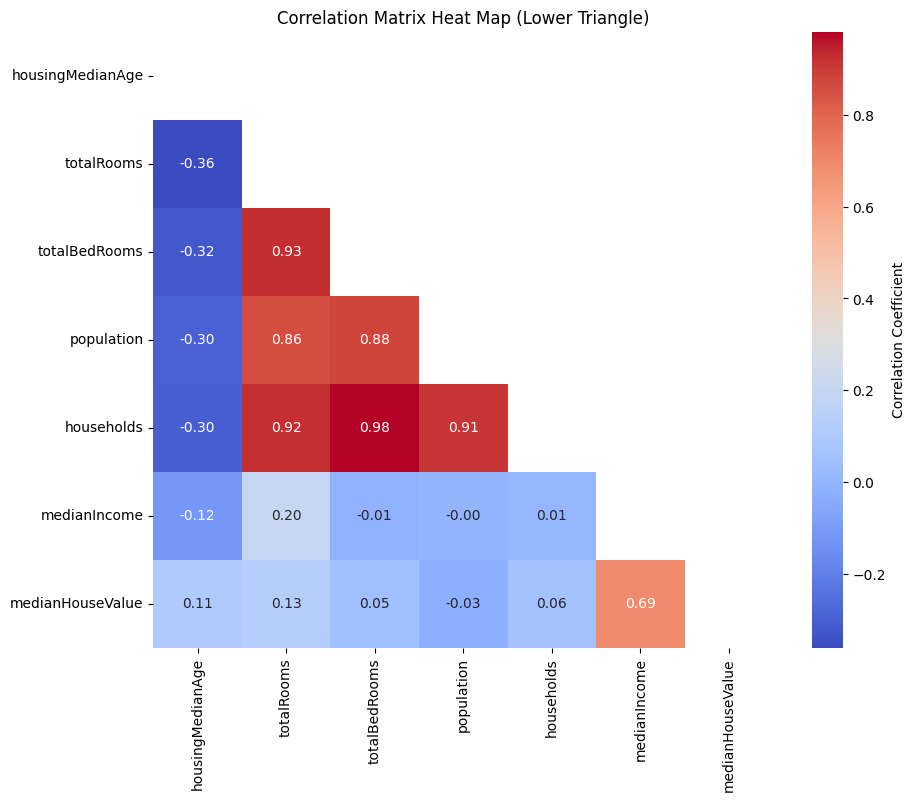

In [91]:
#Convert columns to numeric types, excluding longitude and latitude
numeric_cols = ["housingMedianAge", "totalRooms", "totalBedRooms", "population", "households", "medianIncome", "medianHouseValue"]
df_numeric = df.select([col(col_name).cast("float") for col_name in numeric_cols])

# Convert Spark DataFrame to Pandas DataFrame
pandas_df2 = df_numeric.toPandas()

# Compute the correlation matrix
correlation_matrix = pandas_df2.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create the heat map for the correlation matrix with masked upper triangle
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix Heat Map (Lower Triangle)")
plt.show()

### Descriptive Table

In [92]:
pandas_df2.describe().style.background_gradient(cmap='Blues') \
.set_properties(**{'font-family':'Segoe UI'})

,housingMedianAge,totalRooms,totalBedRooms,population,households,medianIncome,medianHouseValue
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,28.589354,2643.664307,539.410828,1429.573853,501.221954,3.883578,207300.906250
std,12.586937,2179.947021,421.499451,1147.852905,384.520844,1.908157,115983.765625
min,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


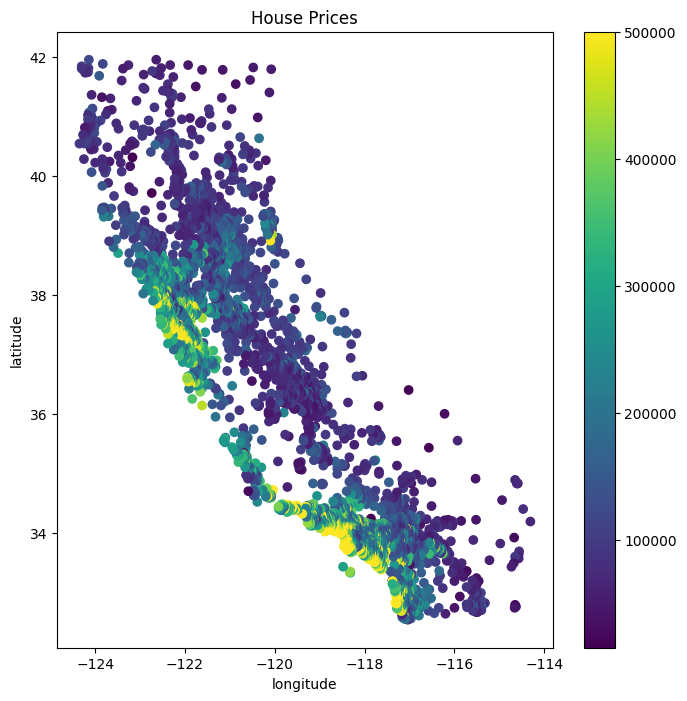

In [93]:
plt.figure(figsize = (8,8))
plt.scatter(pandas_df['longitude'] , pandas_df['latitude'] , c = pandas_df['medianHouseValue'])
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("House Prices")
plt.show()

In [94]:
###Foce to do garbage collection
import gc

# Delete the DataFrame
del pandas_df2

# Force garbage collection
gc.collect()


13076


You should probably standardize your data, as you have seen that the range of minimum and maximum values is quite large.

Your dependent variable is also quite large; you should adjust the values slightly.

**Step 16**: Processing the data

In [95]:
# Adjust the values of `medianHouseValue` - surface the house values in units of 100,000
df = df.withColumn("medianHouseValue", col("medianHouseValue")/100000)

# Show the first 2 lines of `df`
df.take(2)

[Row(longitude=-114.30999755859375, latitude=34.189998626708984, housingMedianAge=15.0, totalRooms=5612.0, totalBedRooms=1283.0, population=1015.0, households=472.0, medianIncome=1.4936000108718872, medianHouseValue=0.669),
 Row(longitude=-114.47000122070312, latitude=34.400001525878906, housingMedianAge=19.0, totalRooms=7650.0, totalBedRooms=1901.0, population=1129.0, households=463.0, medianIncome=1.8200000524520874, medianHouseValue=0.801)]

In [96]:
# Divide `totalRooms` by `households`
roomsPerHousehold = df.select(col("totalRooms")/col("households"))

# Divide `population` by `households`
populationPerHousehold = df.select(col("population")/col("households"))

# Divide `totalBedRooms` by `totalRooms`
bedroomsPerRoom = df.select(col("totalBedRooms")/col("totalRooms"))

# Add the new columns to `df`
df = df.withColumn("roomsPerHousehold", col("totalRooms")/col("households")) \
   .withColumn("populationPerHousehold", col("population")/col("households")) \
   .withColumn("bedroomsPerRoom", col("totalBedRooms")/col("totalRooms"))

# Inspect the result
df.first()

Row(longitude=-114.30999755859375, latitude=34.189998626708984, housingMedianAge=15.0, totalRooms=5612.0, totalBedRooms=1283.0, population=1015.0, households=472.0, medianIncome=1.4936000108718872, medianHouseValue=0.669, roomsPerHousehold=11.889830508474576, populationPerHousehold=2.1504237288135593, bedroomsPerRoom=0.22861724875267284)

In [97]:
# Re-order and select columns
df = df.select("medianHouseValue",
              "totalBedRooms",
              "population",
              "households",
              "medianIncome",
              "roomsPerHousehold",
              "populationPerHousehold",
              "bedroomsPerRoom")

**Step 17**: Specifying the label and the features - the label in this case is the dependent variable i.e. **medianHouseValue**

In [98]:
# Import `DenseVector`
# A Dense Vector is used to store arrays of values for use in PySpark.
from pyspark.ml.linalg import DenseVector

# Define the `input_data`
input_data = df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

# Replace `df` with the new DataFrame
df = spark.createDataFrame(input_data, ["label", "features"])

label = df.rdd.map(lambda x: x.label)
features = df.rdd.map(lambda x: x.features)

Note: <br>

map(lambda x: (x[0], DenseVector(x[1:]))) applies a transformation to each element of the RDD. For each row x, it creates a tuple where the first element is the value of the first column, and the second element is a DenseVector created from the remaining columns.

In [99]:
#Take a look at the first 5 records
df.take(3)

[Row(label=0.669, features=DenseVector([1283.0, 1015.0, 472.0, 1.4936, 11.8898, 2.1504, 0.2286])),
 Row(label=0.801, features=DenseVector([1901.0, 1129.0, 463.0, 1.82, 16.5227, 2.4384, 0.2485])),
 Row(label=0.857, features=DenseVector([174.0, 333.0, 117.0, 1.6509, 6.1538, 2.8462, 0.2417]))]

**Step 18**: Scaling the features using 'StandardScaler' - standardizes a feature of the model by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

**Additional Information**: https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

In [100]:
# Import `StandardScaler`
from pyspark.ml.feature import StandardScaler

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")

# Fit the DataFrame to the scaler
scaler = standardScaler.fit(df.select('features'))

# Transform the data in `df` with the scaler
scaled_df = scaler.transform(df)

# Inspect the result
scaled_df.take(2)

[Row(label=0.669, features=DenseVector([1283.0, 1015.0, 472.0, 1.4936, 11.8898, 2.1504, 0.2286]), features_scaled=DenseVector([3.0439, 0.8843, 1.2275, 0.7827, 4.6825, 0.5326, 3.9537])),
 Row(label=0.801, features=DenseVector([1901.0, 1129.0, 463.0, 1.82, 16.5227, 2.4384, 0.2485]), features_scaled=DenseVector([4.5101, 0.9836, 1.2041, 0.9538, 6.5071, 0.6039, 4.2975]))]

In [101]:
#Check the size of the records
scaled_df.count()

17000

**Step 19**: Create the "Train/Test" split

In [102]:
# Split the DataFrame into training, validation, and test sets
(train_df, val_df, test_df) = scaled_df.withColumn("rand_col", rand()).orderBy("rand_col") \
                                   .randomSplit([0.6, 0.15, 0.25], seed=12345)

# Drop the "rand_col" column from the DataFrames
train_df = train_df.drop("rand_col","features")
val_df = val_df.drop("rand_col","features")
test_df = test_df.drop("rand_col","features")

# Check the structure of the DataFrames
train_df.printSchema()
val_df.printSchema()
test_df.printSchema()


root
 |-- label: double (nullable = true)
 |-- features_scaled: vector (nullable = true)

root
 |-- label: double (nullable = true)
 |-- features_scaled: vector (nullable = true)

root
 |-- label: double (nullable = true)
 |-- features_scaled: vector (nullable = true)



In [103]:
from pyspark.ml.regression import LinearRegression
# Initialize LinearRegression
lr = LinearRegression(featuresCol="features_scaled", labelCol="label")

# Fit the model
linear_model = lr.fit(train_df)

In [104]:
# Make predictions
predictions = linear_model.transform(val_df)

In [105]:
from pyspark.ml.evaluation import RegressionEvaluator
# Evaluate RMSE
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on validation data = {:.4f}".format(rmse))

# Evaluate R-squared (R2)
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on validation data = {:.4f}".format(r2))

Root Mean Squared Error (RMSE) on validation data = 0.9827
R-squared (R2) on validation data = 0.2706


**Step 20**: Make the predictions

In [106]:
# Assuming you have already trained the linear regression model and evaluated it on the datasets
train_metrics = linear_model.evaluate(train_df)
val_metrics = linear_model.evaluate(val_df)
test_metrics = linear_model.evaluate(test_df)

# Extract the relevant metrics
train_rmse = train_metrics.rootMeanSquaredError
train_r2 = train_metrics.r2

val_rmse = val_metrics.rootMeanSquaredError
val_r2 = val_metrics.r2

test_rmse = test_metrics.rootMeanSquaredError
test_r2 = test_metrics.r2

In [107]:
# Create the reuslt comparison table for linear regression model
print("| Model  | Dataset  | RMSE | R-squared |")
print("|--------|----------|------|-----------|")
print("| Linear | Training | {:.2f} |  {:.2f}     |".format(train_rmse, train_r2))
print("|        |Validation| {:.2f} |  {:.2f}     |".format(val_rmse, val_r2))
print("|        |   Test   | {:.2f} |  {:.2f}     |".format(test_rmse, test_r2))

| Model  | Dataset  | RMSE | R-squared |
|--------|----------|------|-----------|
| Linear | Training | 0.76 |  0.57     |
|        |Validation| 0.98 |  0.27     |
|        |   Test   | 0.81 |  0.53     |


In [108]:
# Make predictions on valid data
predicted_val = linear_model.transform(val_df)

In [109]:
# Retrieve the predictions and the "known" labels
predictions_val = predicted_val.select("prediction").rdd.map(lambda x: x[0])
labels_val = predicted_val.select("label").rdd.map(lambda x: x[0])


In [110]:
# Combine the predictions and the label
predictionAndLabel = predictions_val.zip(labels_val).collect()

**Step 21**: Output the predictions and the associated labels

In [111]:
predicted_val.select("label","prediction").show()

+-----+-------------------+
|label|         prediction|
+-----+-------------------+
|0.275| 0.8915578128808684|
| 0.35|0.30624705884559733|
|0.367| 0.7780511489555609|
|0.375|  1.190324393943047|
|0.394| 0.7538819084012655|
|0.427| 0.6112700784558188|
|0.439| 1.1290205604223247|
| 0.44| 0.8829576336335566|
| 0.45| 0.5626234523150931|
|0.467|  0.676437664802762|
|0.475| 1.0488006116109867|
|0.483| 0.9179704082125689|
|0.488| 1.4717060557107087|
|0.494| 0.7272589552199066|
|0.495|  1.088020818389813|
|0.498|  1.229462011050916|
|0.507| 1.0101460206628796|
|0.513| 0.7697673378572002|
|0.515| 0.7694101687973375|
|0.517| 0.8267055753254661|
+-----+-------------------+
only showing top 20 rows



**Step 22**: Evaluating the model

**RMSE**: RMSE measures the differences between predicted values by the model and the actual values.The smaller the RMSE value is, the closer predicted and actual values are.

In [112]:
linear_model.summary.rootMeanSquaredError

0.756297618326895

**R-Squared** known as "Co-efficient of determination" illustrates the extent of the variability in the "MedianHouseValue" that can be explained by the Linear Regression model. The higher the R-squared, the better the model fits the underlying data.

In [113]:
linear_model.summary.r2

0.5737445338330771

About 56% of the variability in the "MedianHouseValues" is explained by the Linear Regression model.There is definitely room for improvement. You can play around with the parameters that you passed to your model.

In [114]:
predicted_test = linear_model.transform(test_df)
predictions_test = predicted_test.select("prediction").rdd.map(lambda x: x[0])
labels_test = predicted_test.select("label").rdd.map(lambda x: x[0])
predictionAndLabel_test = predictions_test.zip(labels_test).collect()

In [115]:
predictionAndLabel_test = predictions_test.zip(labels_test).collect()

# Print the predicted label and true label
for prediction, label in predictionAndLabel_test:
    print(f"Predicted label: {prediction:.2f}, True label: {label:.2f}")

In [116]:
#Randomly select 20 records from the outputs
#with 3 sec between each random draw.
import time
for _ in range(3):
    # Shuffle the list
    import random
    random.shuffle(predictionAndLabel_test)

    # Print the first 20 rows
    for i, (prediction, label) in enumerate(predictionAndLabel_test):
        if i < 20:
            print(f"Predicted label: {prediction:.2f}, True label: {label:.2f}")
        else:
            break

    print("---")
    time.sleep(3)

Predicted label: 1.25, True label: 0.68
Predicted label: 1.50, True label: 1.64
Predicted label: 2.26, True label: 1.86
Predicted label: 2.74, True label: 1.06
Predicted label: 1.03, True label: 0.83
Predicted label: 2.29, True label: 1.01
Predicted label: 1.38, True label: 0.78
Predicted label: 0.58, True label: 0.58
Predicted label: 1.56, True label: 2.19
Predicted label: 0.88, True label: 0.62
Predicted label: 1.86, True label: 1.52
Predicted label: 2.05, True label: 1.94
Predicted label: 3.16, True label: 3.35
Predicted label: 2.99, True label: 2.30
Predicted label: 2.61, True label: 3.95
Predicted label: 1.99, True label: 2.04
Predicted label: 1.64, True label: 2.40
Predicted label: 1.55, True label: 0.81
Predicted label: 1.55, True label: 1.83
Predicted label: 5.09, True label: 5.00
---
Predicted label: 1.71, True label: 2.23
Predicted label: 1.74, True label: 0.99
Predicted label: 3.27, True label: 4.47
Predicted label: 2.40, True label: 2.67
Predicted label: 1.89, True label: 1

# What if we predict the house price as high or low?<br>
Create a binary class--a different model and can't be comparied with the regression model, why?
* need to know the cut-off point

In [117]:
scaled_df.select("label").agg(avg("label")/2).show()


+-----------------+
| (avg(label) / 2)|
+-----------------+
|1.036504561764702|
+-----------------+



In [118]:
from pyspark.ml.classification import LogisticRegression
threshold = scaled_df.select(avg("label") / 2).collect()[0][0]

# Define a threshold function
def convert_to_binary(label):
    return when(label < 1.04, 0).otherwise(1)

# Create a copy of the DataFrame
scaled2 = scaled_df.select('*')
# Apply the threshold function to create binary labels
df2 = scaled2.withColumn("binary_label", convert_to_binary(scaled2["label"]))

# Split the DataFrame into training, validation, and test sets
(train_scaled2, val_scaled2, test_scaled2) = df2.withColumn("rand_col", rand(522)).orderBy("rand_col") \
                                   .randomSplit([0.6, 0.15, 0.25], seed=12345)

# Drop the "rand_col" column from the DataFrames
train_bi = train_scaled2.drop("rand_col","features")
val_bi = val_scaled2.drop("rand_col","features")
test_bi = test_scaled2.drop("rand_col","features")


# Initialize LogisticRegression
logistic_reg = LogisticRegression(featuresCol="features_scaled", labelCol="binary_label")
# Fit the model
logistic_model = logistic_reg.fit(train_bi)

# Make predictions
predictions_bi = logistic_model.transform(val_bi)

# Evaluate the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions_bi)

print("Area Under ROC (AUC) on validation data = {:.4f}".format(auc))



Area Under ROC (AUC) on validation data = 0.9037


In [119]:
predictions_bi.select("label","binary_label", "prediction").show(10)

+-----+------------+----------+
|label|binary_label|prediction|
+-----+------------+----------+
|0.266|           0|       0.0|
|0.367|           0|       0.0|
|0.394|           0|       0.0|
|  0.4|           0|       0.0|
|0.417|           0|       0.0|
|0.438|           0|       0.0|
|0.447|           0|       0.0|
| 0.45|           0|       0.0|
|0.456|           0|       0.0|
|0.469|           0|       1.0|
+-----+------------+----------+
only showing top 10 rows



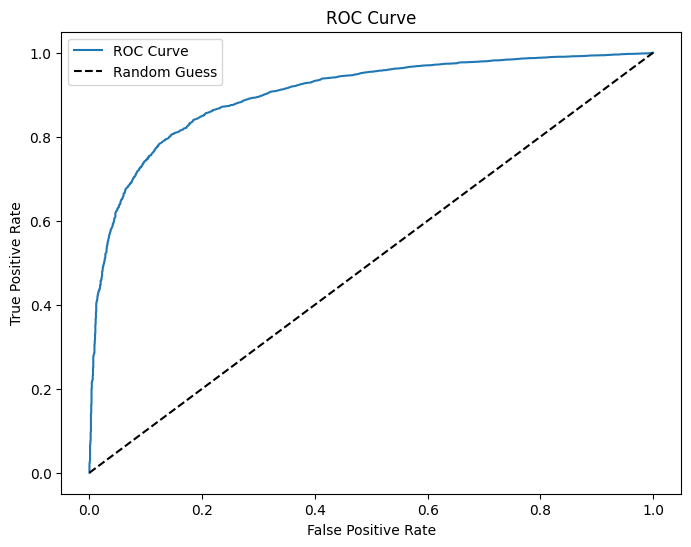

Area Under ROC (AUC) on validation data = 0.9037


In [120]:
# Get the ROC metrics from the logistic regression model
roc = logistic_model.summary.roc.toPandas()

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(False)
plt.show()

# Evaluate the model (Optional, if you haven't done it yet)
evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions_bi)
print("Area Under ROC (AUC) on validation data = {:.4f}".format(auc))

In [121]:
# Delete the DataFrame
del roc

# Force garbage collection
gc.collect()

4244

In [122]:
# Get the coefficients of the logistic regression model
coefficients = logistic_model.coefficients

# Get the intercept of the logistic regression model
intercept = logistic_model.intercept
# Get the feature names
feature_names = ["totalBedRooms", "population", "households", "medianIncome", "roomsPerHousehold", "populationPerHousehold", "bedroomsPerRoom"]  # Replace with your actual feature names

# Print the coefficients of each feature
print("Intercept: {}".format(intercept))
for feature_name, coefficient in zip(feature_names, coefficients):
    print("Coefficient for '{}': {}".format(feature_name, coefficient))




Intercept: -10.31460113634871
Coefficient for 'totalBedRooms': -0.6654661545464264
Coefficient for 'population': -0.2622765055424131
Coefficient for 'households': 1.1279874266418084
Coefficient for 'medianIncome': 3.9626317031684293
Coefficient for 'roomsPerHousehold': 0.08180205583783887
Coefficient for 'populationPerHousehold': 0.030360243104285495
Coefficient for 'bedroomsPerRoom': 1.3229914188134917


### Which feature(s) has more prediction power?

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[ 236.  234.]
 [  99. 1990.]]


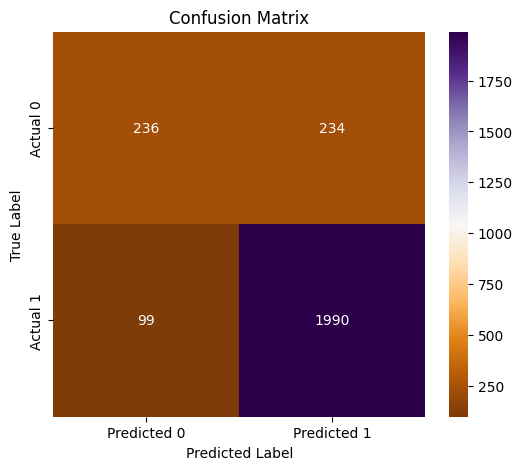

In [123]:
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns needed for the confusion matrix
prediction_and_labels = predictions_bi.select(col("prediction").cast("double"), col("binary_label").cast("double"))

# Convert the DataFrame to an RDD of tuples
prediction_and_labels_rdd = prediction_and_labels.rdd.map(tuple)

# Compute confusion matrix
metrics = MulticlassMetrics(prediction_and_labels_rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)


# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="PuOr", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [124]:
# Confusion matrix
confusion_matrix = [["TN", "FP"],
                    ["FN", "TP"]]

# Print the confusion matrix
print("Confusion Matrix:")
print("       Pred")
print("        0  1")
print("True 0 ", confusion_matrix[0][0], confusion_matrix[0][1])
print("     1 ", confusion_matrix[1][0], confusion_matrix[1][1])

Confusion Matrix:
       Pred
        0  1
True 0  TN FP
     1  FN TP


Confusion matrix is confusing:

---

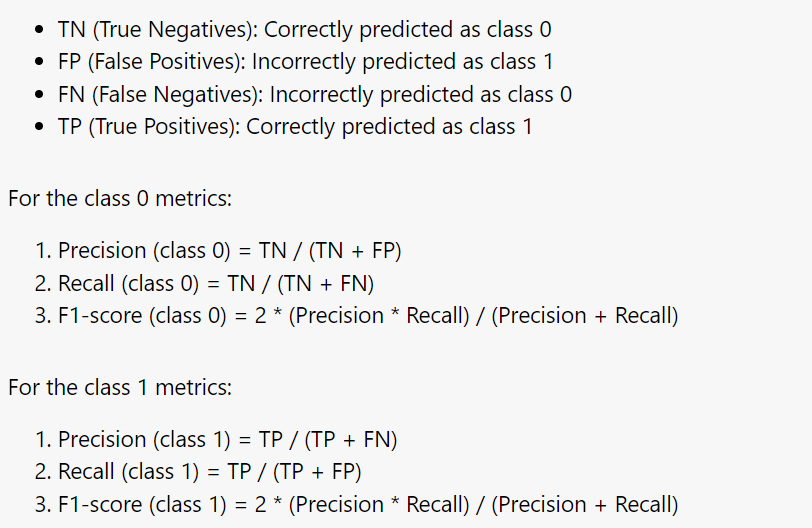

In [125]:
def plot_confusion_matrix(predictions_df, prediction_col, label_col):
    # Select the columns needed for the confusion matrix
    prediction_and_labels = predictions_df.select(col(prediction_col).cast("double"), col(label_col).cast("double"))

    # Convert the DataFrame to an RDD of tuples
    prediction_and_labels_rdd = prediction_and_labels.rdd.map(tuple)

    # Compute confusion matrix
    metrics = MulticlassMetrics(prediction_and_labels_rdd)
    confusion_matrix = metrics.confusionMatrix().toArray()

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="PuOr", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[ 236.  234.]
 [  99. 1990.]]


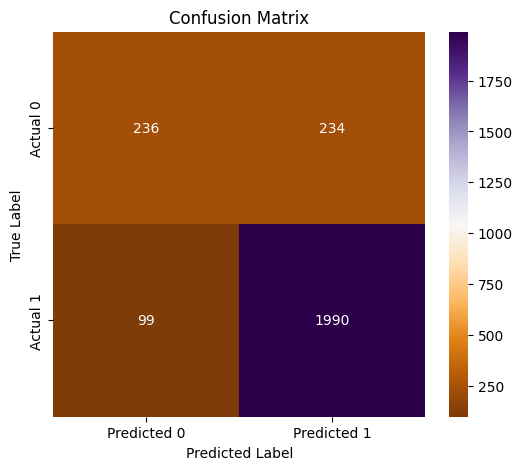

In [126]:
plot_confusion_matrix(predictions_bi, "prediction", "binary_label")

In [127]:
# Make predictions on test
predictions_bi_test = logistic_model.transform(test_bi)

#evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_test = evaluator.evaluate(predictions_bi_test)

print("Area Under ROC (AUC) on validation data = {:.4f}".format(auc_test))


Area Under ROC (AUC) on validation data = 0.8990


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
[[ 435.  395.]
 [ 194. 3275.]]


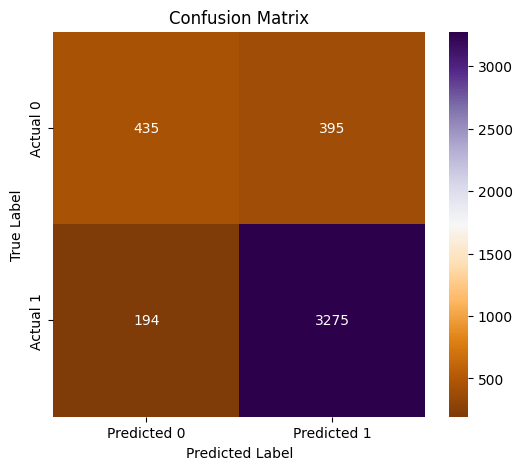

In [128]:
plot_confusion_matrix(predictions_bi_test, "prediction", "binary_label")

In [129]:
# Extract true positives, false positives, and false negatives from the confusion matrix
confusion_matrix = [[ 435.,  395.],
                    [ 194., 3275.]]

tp_0 = confusion_matrix[0][0]
fp_0 = confusion_matrix[0][1]
fn_0 = confusion_matrix[1][0]

tp_1 = confusion_matrix[1][1]
fp_1 = confusion_matrix[1][0]
fn_1 = confusion_matrix[0][1]

# Calculate precision, recall, and F1 score for class 0 (Negative class)
precision_0 = tp_0 / (tp_0 + fp_0)
recall_0 = tp_0 / (tp_0 + fn_0)
f1_score_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)

# Calculate precision, recall, and F1 score for class 1 (Positive class)
precision_1 = tp_1 / (tp_1 + fp_1)
recall_1 = tp_1 / (tp_1 + fn_1)
f1_score_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)

# Print the results
print("Class 0 - Negative class:")
print("Precision:", precision_0)
print("Recall:", recall_0)
print("F1 Score:", f1_score_0)

print("\nClass 1 - Positive class:")
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1 Score:", f1_score_1)

Class 0 - Negative class:
Precision: 0.5240963855421686
Recall: 0.6915739268680445
F1 Score: 0.5962988348183688

Class 1 - Positive class:
Precision: 0.9440761026232344
Recall: 0.8923705722070845
F1 Score: 0.9174954475416726


### What is your observations based on the metric scores from validation/test datasets?--This is your analysis of the results.
### What is the conclusion that covers your reserach question?
### What is your thoughts about your modeling design, do you see room for improvement?---this is the part of limitations.

References:

https://www.kaggle.com/code/abdelaziznabil/california-housing-prices-data-modeling